This code is an initial exploratory data analysis. The main purpose of this document is to clean raw data values of stock & social media, organize the mapping between dates and trading days, begin making control values for stock data, and create graphical representations. 

In [228]:
#Import all libraries.
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
import sys
import os


In [229]:
#Importing and organizing stock data 
import yfinance as yf

sp500_tickers = ["WMT", "AMZN", "AAPL", "CVS", "TSLA", "GOOGL", "META", "JPM", "COST", "KR",
"WBA", "TGT", "UPS", "CNC", "CI", "MSFT", "VZ", "IBM", "UNH", "XOM",
"MCK", "CVX", "CAH", "HD", "WBA", "MPC", "COR", "F", "C", "DELL",
"GM", "NVDA", "PFE", "PG", "CMCSA", "JNJ", "WFC", "BAC", "ABBV", "SBUX",
"CSCO", "T", "PEP", "INTC", "DIS", "BA", "GS", "MS", "HON", "CRM"
]

# Get the data for tickers from yahoo finance

# Download Close price data for tickers
stock_data_unordered = yf.download(sp500_tickers, '2023-01-01', '2025-10-02', auto_adjust=True)['Close']

# Download S&P 500 index data
SP500 = yf.download('^GSPC', '2023-01-01', '2025-10-02', auto_adjust=True)['Close']

# Transpose stock data so tickers are row index
stock_data_unordered = stock_data_unordered.T

# Reorder rows by original ticker list order
stock_data = stock_data_unordered.loc[sp500_tickers]
stock_data = stock_data.T


[*********************100%***********************]  49 of 49 completed

1 Failed download:
['WBA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2025-10-02) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed


Note: In the course of this project, "WBA" gets removed from YahooFinance, and gets excluded from our company list. 

In [230]:
#log returns
sd = stock_data.T
log_returns= np.log(sd/sd.shift(1)).dropna()
SP_log_returns = np.log(SP500/SP500.shift(1)).dropna()

#Percentage change in stock returns day-to-day (in lieu of trading day variance)
SP_pct_change = SP500.pct_change().dropna()
sd2 = stock_data
pct_change = sd2.pct_change()
pct_change = pct_change[1:]

#variance of stock returns over each week in the period (5 trading days) 
SP_weekly_variance = SP_log_returns.rolling(window=5).var().dropna()
wv = log_returns.T.rolling(window=5).var().dropna()
weekly_variance = wv

#variance of stock returns over each month in the period (21 trading days)
SP_monthly_variance = SP_log_returns.rolling(window=21).var().dropna()
monthly_variance = log_returns.T.rolling(window=21).var().dropna()

#variance of stock returns over each 2 weeks in the period (10 trading days)
SP_biweekly_variance = SP_log_returns.rolling(window=10).var().dropna()
biweekly_variance = log_returns.T.rolling(window=10).var().dropna()
print(biweekly_variance)
#super averages
#average percent change in a single day
Av_SP_pct_change = SP_pct_change.mean()
av_pct_change = pct_change.mean()

#average weekly variance
av_weekly_variance = weekly_variance.mean()
Av_SP_weekly_variance = SP_weekly_variance.T.mean()

#average monthly variance
transpose_monthly = monthly_variance
av_monthly_variance = transpose_monthly.mean()
Av_SP_monthly_variance = SP_monthly_variance.T.mean()
#average biweekly variance
av_biweekly_variance = biweekly_variance.mean()
Av_SP_biweekly_variance = SP_biweekly_variance.T.mean()


#Note: variance windows are in trading days, not calendar days. Moreover, these are backwards looking rolling variances.

C:\Users\Thisu\AppData\Local\Temp\ipykernel_26468\2705123083.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_change = sd2.pct_change()


Ticker          AMZN      AAPL       CVS      TSLA     GOOGL      META  \
Date                                                                     
2023-01-17  0.003307  0.001095  0.001773  0.005129  0.002102  0.000459   
2023-01-18  0.003776  0.001136  0.001569  0.004555  0.001460  0.000177   
2023-01-19  0.003695  0.001044  0.001368  0.004342  0.001264  0.000137   
2023-01-20  0.003074  0.000823  0.001229  0.004114  0.000892  0.000288   
2023-01-23  0.001950  0.000534  0.001357  0.004877  0.000850  0.000334   
...              ...       ...       ...       ...       ...       ...   
2025-09-25  0.000525  0.003416  0.000873  0.000757  0.000762  0.000180   
2025-09-26  0.000639  0.003622  0.000643  0.000258  0.000937  0.000142   
2025-09-29  0.000636  0.003285  0.000601  0.000275  0.001027  0.000139   
2025-09-30  0.000550  0.002648  0.000563  0.000363  0.001266  0.000126   
2025-10-01  0.000497  0.001930  0.000452  0.000525  0.001778  0.000229   

Ticker           JPM      COST       

The following code imports bluesky data and maps social media days to trading days. 

In [231]:

#Bs_data contains all bluesky posts containing any keywords
bs_data= pd.read_csv('bluesky_allkeywords.csv')
days = list(bs_data.columns)[1:]
#td_data contains all posts except those mentioning only CEO name
td_data = pd.read_csv('bluesky_ticker.csv')

#Functions to test if a date is a trading day
def is_trading_day(date):
    return date in stock_data.index

#outputs next trading days
def next_trading_day(day):
    date = dt.datetime.strptime(day, '%Y-%m-%d')
    next_day = date + dt.timedelta(1)
    max_lookahead = 365  # prevent infinite loop going 1 year ahead
    count = 0
    while not is_trading_day(next_day):
        next_day += dt.timedelta(1)
        count += 1
        if count > max_lookahead:
            raise ValueError("No trading day found within 1 year from start date")
    return next_day.strftime('%Y-%m-%d')

#This maps social media count from non-trading days to the next trading day. 
for day in days:
   if is_trading_day(day) == False:
       bs_data[next_trading_day(day)] = bs_data[day] + bs_data[next_trading_day(day)]
       bs_data = bs_data.drop(columns=[day])
       td_data[day] = td_data[day] + td_data[next_trading_day(day)]
       td_data = td_data.drop(columns=[day])

#match up data with dates/ticker order
sd = stock_data
match_stock_data = sd['2024-07-31': '2025-07-30']
match_sd_pct_change = match_stock_data.pct_change()
match_sd_pct_change = match_sd_pct_change.drop('2024-07-31')
bs_data.index = sp500_tickers
td_data.index = sp500_tickers

C:\Users\Thisu\AppData\Local\Temp\ipykernel_26468\3867372559.py:35: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  match_sd_pct_change = match_stock_data.pct_change()


C:\Users\Thisu\AppData\Local\Temp\ipykernel_26468\2678660547.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_day_forward = day_forward.pct_change()


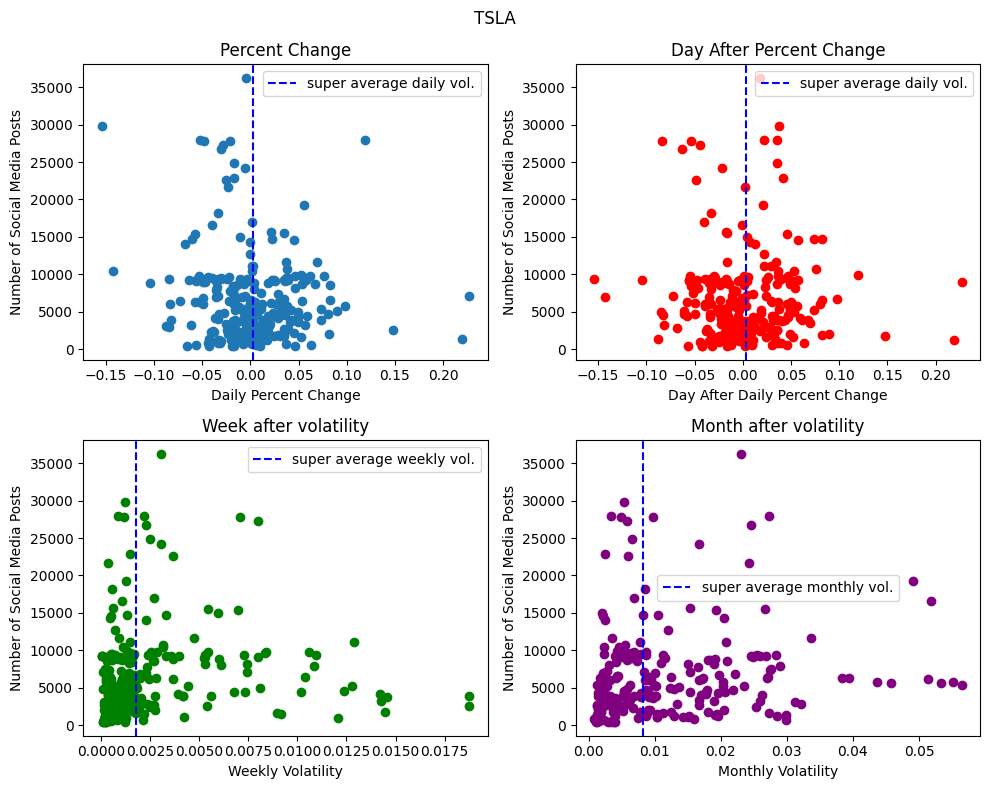

In [232]:
import matplotlib.pyplot as plt
company = 'TSLA'
x = match_sd_pct_change
y = bs_data.T

# Other plot values to compare
day_forward = sd['2024-08-01': '2025-07-31']
pct_day_forward = day_forward.pct_change()
pct_day_forward = pct_day_forward.drop('2024-08-01')
x2 = pct_day_forward
week_after = weekly_variance['2024-08-08': '2025-08-06']
x3 = week_after
month_after = monthly_variance['2024-09-01': '2025-09-01']
x4 = month_after

# Graph data to view initial relationships
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 
fig.suptitle(company)

# Plot 1
axs[0, 0].scatter(x[company], y[company][1:])
axs[0, 0].axvline(x=av_pct_change[company], color='b', linestyle='--', label="super average daily vol.")
axs[0, 0].set_title('Percent Change')
axs[0, 0].set_xlabel('Daily Percent Change')
axs[0, 0].set_ylabel('Number of Social Media Posts')
axs[0, 0].legend()

# Plot 2
axs[0, 1].scatter(x2[company], y[company][1:], color='red')
axs[0, 1].axvline(x=av_pct_change[company], color='b', linestyle='--', label="super average daily vol.")
axs[0, 1].set_title('Day After Percent Change')
axs[0, 1].set_xlabel('Day After Daily Percent Change')
axs[0, 1].set_ylabel('Number of Social Media Posts')
axs[0, 1].legend()

# Plot 3
axs[1, 0].scatter(x3[company], y[company][1:], color='green')
axs[1, 0].axvline(x=av_weekly_variance[company], color='b', linestyle='--', label="super average weekly vol.")
axs[1, 0].set_title('Week after volatility')
axs[1, 0].set_xlabel('Weekly Volatility')
axs[1, 0].set_ylabel('Number of Social Media Posts')
axs[1, 0].legend()

# Plot 4
axs[1, 1].scatter(x4[company], y[1:][company], color='purple')
axs[1, 1].axvline(x=av_monthly_variance[company], color='b', linestyle='--', label="super average monthly vol.")
axs[1, 1].set_title('Month after volatility')
axs[1, 1].set_xlabel('Monthly Volatility')
axs[1, 1].set_ylabel('Number of Social Media Posts')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


Initial analysis on several companies does not reveal an obvious relationship between social media and volatility. More complex EDA needs to be completed to find hints of non-linear relationships. 

The following code explores aggregate weekly/monthly post quantity versus weekly/monthly volatility in hopes of finding a relationship. 

Ticker          AMZN      AAPL       CVS      TSLA     GOOGL      META  \
Date                                                                     
2024-08-14  0.000813  0.000846  0.001511  0.000810  0.000345  0.001615   
2024-08-15  0.000216  0.000107  0.001535  0.001071  0.000758  0.001572   
2024-08-16  0.000232  0.000101  0.001546  0.001293  0.001125  0.001014   
2024-08-19  0.000189  0.000121  0.001275  0.001562  0.001499  0.000568   
2024-08-20  0.000185  0.000143  0.000628  0.001537  0.001703  0.000530   
...              ...       ...       ...       ...       ...       ...   
2025-07-24  0.000062  0.000077  0.001156  0.001647  0.000974  0.000714   
2025-07-25  0.000061  0.000080  0.001102  0.001265  0.001247  0.000600   
2025-07-28  0.000055  0.000092  0.000997  0.001204  0.001228  0.000356   
2025-07-29  0.000069  0.000119  0.000746  0.000668  0.001402  0.000439   
2025-07-30  0.000057  0.000149  0.000674  0.000630  0.001481  0.000607   

Ticker           JPM      COST       

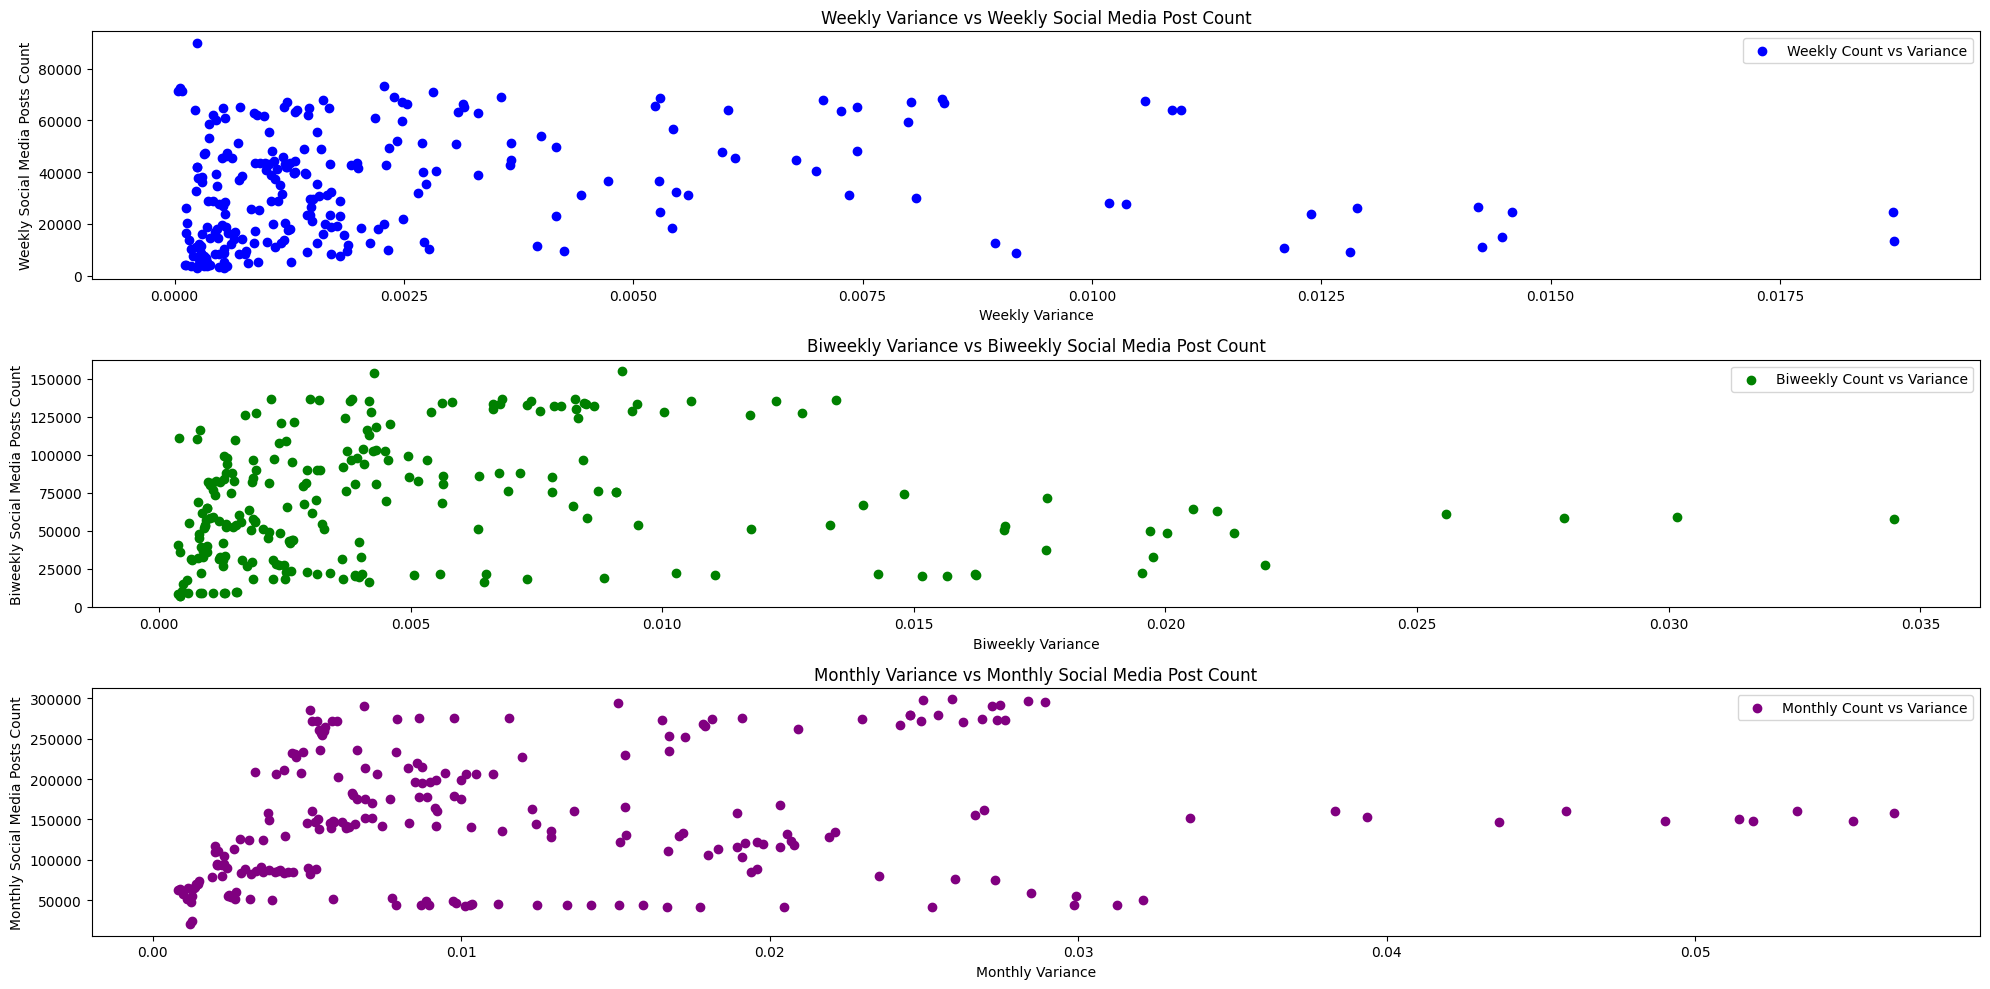

In [233]:
#Experiment with weekly counts of posts vs weekly variance
bs_new = bs_data.drop('company', axis=1)
bs_weekly = bs_new.T.rolling(window=5).sum()
bs_weekly = bs_weekly.iloc[4:]
instant_weekly = weekly_variance['2024-08-07': '2025-07-30']

#biweekly vs biweekly variance
bs_biweekly = bs_new.T.rolling(window=10).sum()
bs_biweekly = bs_biweekly.iloc[9:]
instant_biweekly = biweekly_variance['2024-08-14':'2025-07-30']
print(instant_biweekly)
#monthly count vs monthly variance
bs_monthly = bs_new.T.rolling(window=21).sum()
bs_monthly = bs_monthly.iloc[20:]
instant_monthly = monthly_variance['2024-08-29': '2025-07-30']


fig, ax = plt.subplots(3, 1, figsize=(20, 10)) 
# Weekly
ax[0].scatter(instant_weekly[company], bs_weekly[company], label='Weekly Count vs Variance', color='blue')
ax[0].set_title("Weekly Variance vs Weekly Social Media Post Count")
ax[0].set_xlabel("Weekly Variance")
ax[0].set_ylabel("Weekly Social Media Posts Count")
ax[0].legend()

# Biweekly
ax[1].scatter(instant_biweekly[company], bs_biweekly[company], label='Biweekly Count vs Variance', color='green')
ax[1].set_title("Biweekly Variance vs Biweekly Social Media Post Count")
ax[1].set_xlabel("Biweekly Variance")
ax[1].set_ylabel("Biweekly Social Media Posts Count")
ax[1].legend()

# Monthly
ax[2].scatter(instant_monthly[company], bs_monthly[company], label='Monthly Count vs Variance', color='purple')
ax[2].set_title("Monthly Variance vs Monthly Social Media Post Count")
ax[2].set_xlabel("Monthly Variance")
ax[2].set_ylabel("Monthly Social Media Posts Count")
ax[2].legend()

plt.tight_layout()
plt.show()

Here, we are also not seeing a clear relationship, though this may be an interesting path of analysis. To streamline our analysis, we will focus on predicting daily/weekly/monthly volatility in correspondence to social media posts. 

In response to the lack of relationships exhibited above, below is an experiment comparing Telsa CEO Elon Musk's tweet count in relation to total social media posts mentioning TSLA and the stock's volatility. 

C:\Users\Thisu\AppData\Local\Temp\ipykernel_26468\3904824127.py:2: DtypeWarning: Columns (11,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  elon_data= pd.read_csv('all_musk_posts.csv')
[*********************100%***********************]  1 of 1 completed


Ticker           TSLA
Date                 
2024-08-02  -0.361210
2024-08-05  -0.001226
2024-08-06  -1.203720
2024-08-07  -6.137866
2024-08-08  -1.800922
...               ...
2025-03-25  -0.694653
2025-03-26  -2.668162
2025-03-27  -1.068356
2025-03-28 -10.096149
2025-03-31  -0.529548

[165 rows x 1 columns]


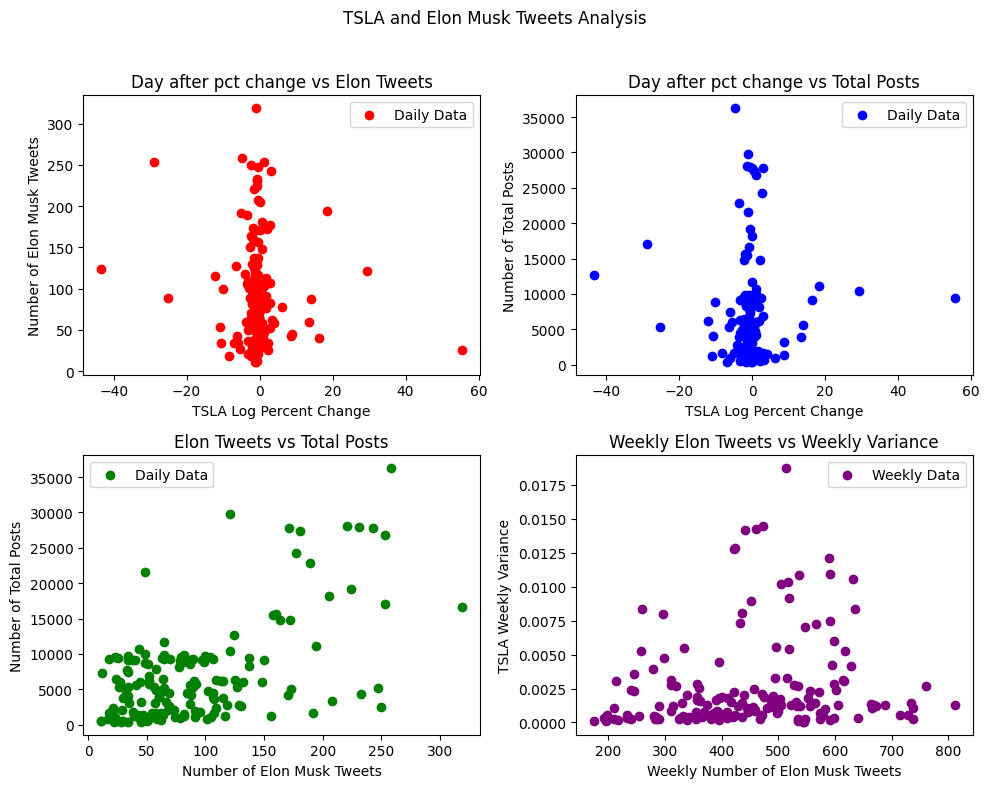

In [236]:
#study with TSLA and Elon Musk Tweets
elon_data= pd.read_csv('all_musk_posts.csv')
elon_data = elon_data["createdAt"]
elon_data = pd.to_datetime(elon_data)
elon_data = elon_data.dt.date
elon_data = elon_data.value_counts().sort_index()
elon_data = elon_data.reset_index()
elon_data.columns = ['date', 'tweets']
elon_data = elon_data.sort_values(by='date')

#Restrict to tweet counts from 2024-08-01 to 2025-03-31
elon_data = elon_data[(elon_data['date'] >= dt.date(2024, 8, 1)) & (elon_data['date'] <= dt.date(2025, 3, 28))]
elon_data = elon_data.set_index('date')
elon_data = elon_data.asfreq('D', fill_value=0)
elon_data = elon_data.reset_index()


TSLA_stock = yf.download('TSLA', '2024-07-31', '2025-04-01', auto_adjust=True)['Close']

tsla_log_returns = np.log(TSLA_stock/TSLA_stock.shift(1)).dropna()
tsla_pct_change = tsla_log_returns.pct_change().dropna()
print(tsla_pct_change)
tsla_dates = TSLA_stock.index


# Combine tweet counts on non-trading days to the next trading day, and delete non-trading days
def is_trading_day(day):
    return day in tsla_dates


def next_trading_day(day):
    date = day #dt.datetime.strptime(day, '%Y-%m-%d')
    next_day = date + dt.timedelta(1)
    max_lookahead = 365  # prevent infinite loop going 1 year ahead
    count = 0
    while not is_trading_day(next_day.strftime('%Y-%m-%d')):
        next_day += dt.timedelta(1)
        count += 1
        if count > max_lookahead:
            print(day)
            raise ValueError("No trading day found within 1 year from start date")
    return next_day#.strftime('%Y-%m-%d')


elon_data['date'] = elon_data['date'].dt.date
days = elon_data['date']

elon_data.set_index('date', inplace=True)
elon_data = elon_data.T

for day in days:
   if is_trading_day(day.strftime('%Y-%m-%d')) == False:
      elon_data[next_trading_day(day)] = elon_data[day] + elon_data[next_trading_day(day)]
      elon_data= elon_data.drop(columns=[day])



elon_data = elon_data.T

y=bs_data.T

y = y['2024-08-01': '2025-03-28']


elon_data_weekly = elon_data.rolling(window=5).sum()
elon_data_weekly= elon_data_weekly.iloc[4:]
weekly_variance = weekly_variance['2024-08-07': '2025-03-28']

fig, axs = plt.subplots(2,2, figsize=(10, 8)) 
fig.suptitle('TSLA and Elon Musk Tweets Analysis')

# Plot 1: Log returns vs Elon Tweets
axs[0,0].scatter(tsla_pct_change["TSLA"], elon_data['tweets'], color='red', label='Daily Data')
axs[0,0].set_title('Day after pct change vs Elon Tweets')
axs[0,0].set_xlabel('TSLA Log Percent Change')
axs[0,0].set_ylabel('Number of Elon Musk Tweets')
axs[0,0].legend()

# Plot 2: Log returns vs total posts
axs[0,1].scatter(tsla_pct_change["TSLA"], y['TSLA'], color='blue', label='Daily Data')
axs[0,1].set_title('Day after pct change vs Total Posts')
axs[0,1].set_xlabel('TSLA Log Percent Change')
axs[0,1].set_ylabel('Number of Total Posts')
axs[0,1].legend()

# Plot 3: Elon tweets vs total posts
axs[1,0].scatter(elon_data['tweets'], y["TSLA"], color='green', label='Daily Data')
axs[1,0].set_title('Elon Tweets vs Total Posts')
axs[1,0].set_xlabel('Number of Elon Musk Tweets')
axs[1,0].set_ylabel('Number of Total Posts')
axs[1,0].legend()

# Plot 4: Weekly Elon tweets vs weekly variance
axs[1,1].scatter(elon_data_weekly['tweets'], weekly_variance['TSLA'], color='purple', label='Weekly Data')
axs[1,1].set_title('Weekly Elon Tweets vs Weekly Variance')
axs[1,1].set_xlabel('Weekly Number of Elon Musk Tweets')
axs[1,1].set_ylabel('TSLA Weekly Variance')
axs[1,1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Observations here are that the distributions for daily pct change day after tweets for both all posts and Elon Musk tweets are remarkably similar. The weekly Elon Musk tweets vs Weekly variance also shows some stronger linearity. There also appears to be a relationship between total number of posts and number of Elon Musk posts. 

It would be interesting to review this more for more CEOs/companies and the relationships therein. Due to time constraints and the arduous task of collecting each CEO tweet count, this is beyond the scope of this project. This is, however, a possible branch of study for future projects.